In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, auc, roc_auc_score, roc_curve,  mean_squared_error
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout, LSTM

from xgboost import XGBClassifier
from scipy.io import arff

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# %load preprocessing.py
import matplotlib.pyplot as plt

def convert_object_to_numeric(data):
    for column in data.select_dtypes(include='object').columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
    return data

def plot_data(data):
    Defective = data['Defective'][data.Defective == True].shape[0]
    non_Defective = data['Defective'][data.Defective == False].shape[0]
    defect_count = [Defective, non_Defective]
    defect_label = ['defect', 'non_Defective']
    plt.bar(defect_label, defect_count)
    for i, count in enumerate(defect_count):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

def extract_and_eval(data):
    '''
    input: data
    goal: make an evaluation to every sample and label
    '''
    eval = (data.n < 300) & (data.v < 1000) & (data.d < 50) & (data.e < 500000) & (data.t < 5000)   
    data['eval'] = pd.DataFrame(eval)
    data['eval'] = [1 if e == True else 0 for e in data['eval']]

def evaluate(y_test, predictions, model):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    fpr = fp / (tn + fp)
    fnr = fn / (tp + fn)
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(predictions, y_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    metrics = {'Accuracy': accuracy,
               'Precision': precision,
               'Recall': recall,
               'FPR': fpr,
               'FNR': fnr,
               'AUC': auc}

    df = pd.DataFrame.from_dict(metrics, orient='index', columns=['value'])

    # Create a subplot within the figure and plot the evaluation results
    plt.subplot(1, 2, 1)
    sns.barplot(x=df.index, y='value', data=df)

    for i, v in enumerate(df['value']):
        plt.text(i, v + 0.01, str(round(v, 2)), ha='center')

    plt.title(f"{model.__class__.__name__}")
    plt.ylabel("Score")

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Create a subplot within the figure and plot the ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

def plot_evaluation(y_test, predictions, model):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the evaluation results in the first subplot
    plt.sca(axs[0])
    evaluate(y_test, predictions, model)

    # Plot the ROC curve in the second subplot
    plt.sca(axs[1])
    plot_roc_curve(y_test, predictions)

    # Show the figure
    plt.tight_layout()
    plt.show()

x = 0
y = 0
def cvs(model, x=x, y=y, n=10):
    cv = RepeatedStratifiedKFold(n_splits=n, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return n_scores.mean()

In [54]:
# path = os.path.join(DATADIR, 'jm1.csv')
# data = pd.read_csv("/content/drive/MyDrive/training/jm1.csv")
data = arff.loadarff('../archive/MW1.arff')
data = pd.DataFrame(data[0])

In [6]:
data.head()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,5.0,7.0,13.0,0.0,7.0,8.0,4.0,0.16,4.0,2.0,...,24.0,0.11,37.0,47.0,28.0,9.0,38.0,21.88,25.0,b'N'
1,5.0,21.0,3.0,1.0,2.0,24.0,11.0,0.30,4.0,6.0,...,23.0,0.24,75.0,86.0,32.0,16.0,45.0,7.69,37.0,b'N'
2,2.0,5.0,0.0,0.0,4.0,8.0,3.0,0.33,4.0,2.0,...,9.0,0.19,10.0,17.0,6.0,9.0,16.0,30.77,9.0,b'N'
3,3.0,5.0,3.0,0.0,15.0,8.0,3.0,0.19,4.0,2.0,...,12.0,0.09,22.0,33.0,12.0,14.0,35.0,48.39,16.0,b'Y'
4,3.0,5.0,2.0,0.0,5.0,8.0,3.0,0.43,4.0,2.0,...,12.0,0.19,19.0,22.0,8.0,10.0,16.0,41.67,7.0,b'N'


In [55]:
# data['Defective']=[1 if val==b'Y' else 0 for val in data['Defective']]
data['Defective']=[1 if val==b'Y' else 0 for val in data['Defective']]


In [8]:
cols = data.columns
cols, len(cols)

(Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
        'LOC_COMMENTS', 'CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY',
        'CYCLOMATIC_DENSITY', 'DECISION_COUNT', 'DECISION_DENSITY',
        'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'EDGE_COUNT',
        'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE',
        'PARAMETER_COUNT', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY',
        'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH',
        'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME',
        'MAINTENANCE_SEVERITY', 'MODIFIED_CONDITION_COUNT',
        'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT',
        'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_OPERANDS', 'NUM_OPERATORS',
        'NUM_UNIQUE_OPERANDS', 'NUM_UNIQUE_OPERATORS', 'NUMBER_OF_LINES',
        'PERCENT_COMMENTS', 'LOC_TOTAL', 'Defective'],
       dtype='object'),
 38)

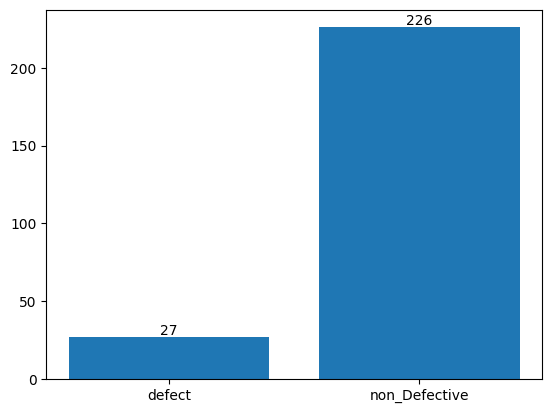

In [9]:
plot_data(data)

In [10]:
data.isna().sum()

LOC_BLANK                          0
BRANCH_COUNT                       0
CALL_PAIRS                         0
LOC_CODE_AND_COMMENT               0
LOC_COMMENTS                       0
CONDITION_COUNT                    0
CYCLOMATIC_COMPLEXITY              0
CYCLOMATIC_DENSITY                 0
DECISION_COUNT                     0
DECISION_DENSITY                   0
DESIGN_COMPLEXITY                  0
DESIGN_DENSITY                     0
EDGE_COUNT                         0
ESSENTIAL_COMPLEXITY               0
ESSENTIAL_DENSITY                  0
LOC_EXECUTABLE                     0
PARAMETER_COUNT                    0
HALSTEAD_CONTENT                   0
HALSTEAD_DIFFICULTY                0
HALSTEAD_EFFORT                    0
HALSTEAD_ERROR_EST                 0
HALSTEAD_LENGTH                    0
HALSTEAD_LEVEL                     0
HALSTEAD_PROG_TIME                 0
HALSTEAD_VOLUME                    0
MAINTENANCE_SEVERITY               0
MODIFIED_CONDITION_COUNT           0
M

In [11]:
data.shape

(253, 38)

In [92]:
x = pd.DataFrame(data.drop('Defective', axis=1))
# y = pd.DataFrame(data["defects"])
# x = pd.DataFrame(data[features]).drop('defects', axis=1)
y = pd.DataFrame(data["Defective"])

In [93]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)
x, y = ros.fit_resample(x.values, y.values)
data_scaled = pd.DataFrame(x)
# data_scaled.columns = cols[:-1]
# data_scaled.columns = features[:-1]
data_scaled['Defective'] = y

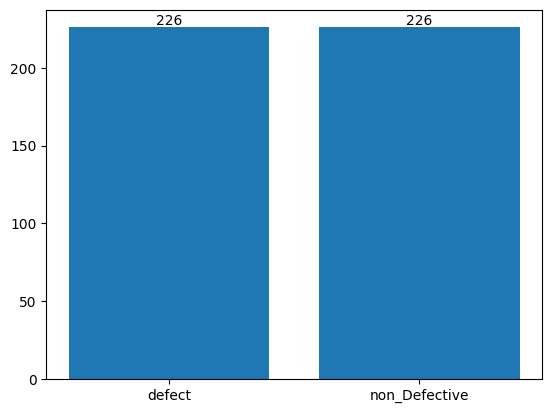

In [94]:
plot_data(data_scaled)

In [95]:
x = scaler.fit_transform(x)


In [96]:
"""
Split the data train & data test & also the data validation
"""
x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=y, test_size=0.3, random_state=1
)
# x_train, x_test, y_train, y_test = train_test_split(
#     x_scaled, y_scaled, test_size=0.2, random_state=1
# )

In [97]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x_train_ = scaler.fit_transform(x_train)
x_test_ = scaler.transform(x_test)

In [98]:
x_scaled_ = scaler.fit_transform(x)

### Logistic Regression

In [99]:
model = LogisticRegression()
model.fit(x_train_, y_train)
predictions = model.predict(x_test_)

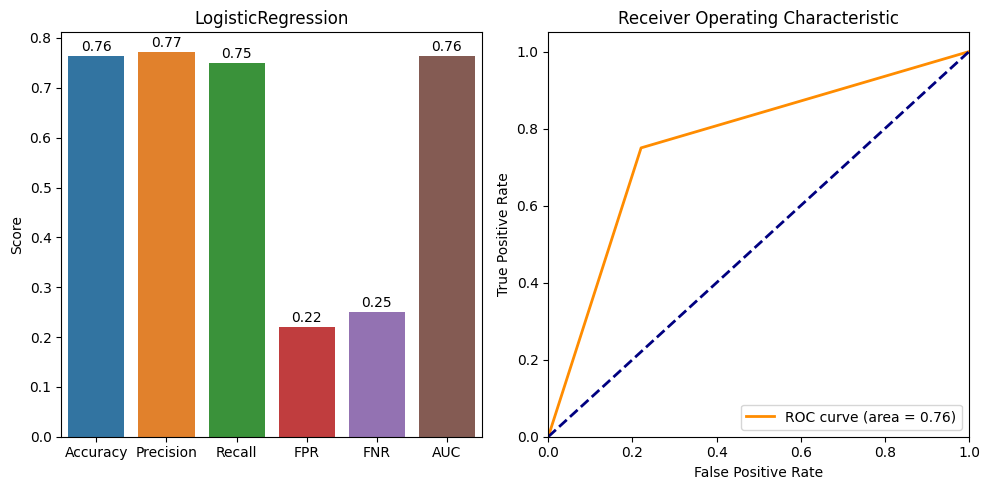

In [100]:
plot_evaluation(y_test, predictions, model)

### Decision Tree

In [101]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train_, y_train)
predictions = tree.predict(x_test_)

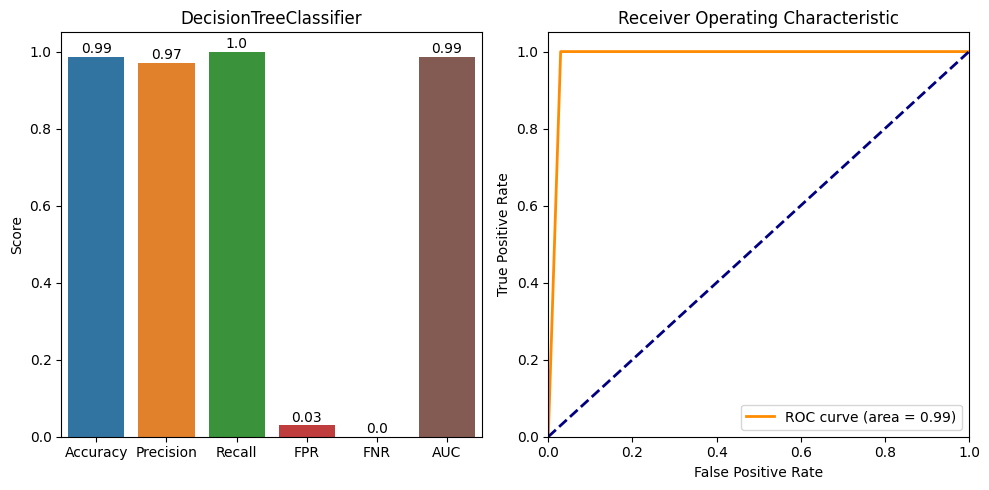

In [102]:
plot_evaluation(y_test, predictions, tree)

In [103]:
xgb = XGBClassifier(
    max_depth=11,
    learning_rate=0.1,
    n_estimators=500,
    reg_alpha=1.1,
    colsample_bytree = 0.9,
    subsample = 0.9,
    n_jobs = -1
)

### XGBoost

In [104]:
xgb.fit(x_train_, y_train, eval_set=[(x_test_, y_test)], verbose=False, early_stopping_rounds=2)
# pred
pred = xgb.predict(x_test_)

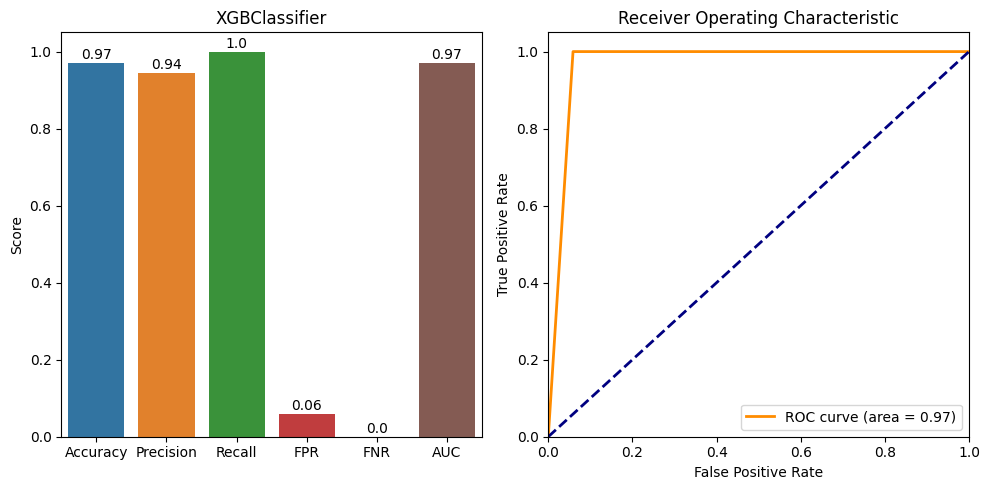

In [105]:
plot_evaluation(y_test, pred, xgb)

### Random Forest

In [106]:
randomforest = RandomForestClassifier()
randomforest.fit(x_train_, y_train)

RandomForestClassifier()

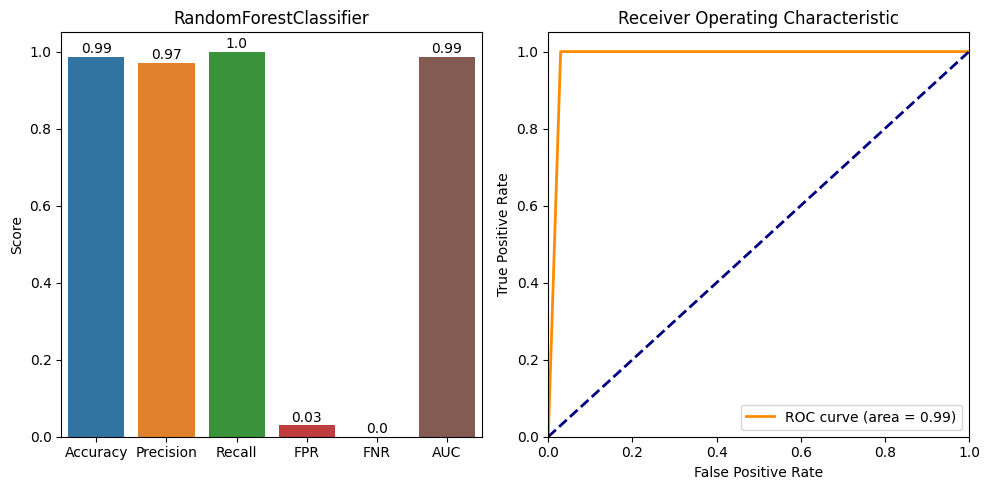

In [107]:
plot_evaluation(y_test, randomforest.predict(x_test_), randomforest)

### Ada Boost

In [108]:
ada = AdaBoostClassifier(learning_rate=0.1, n_estimators=300)
ada.fit(x_train_, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=300)

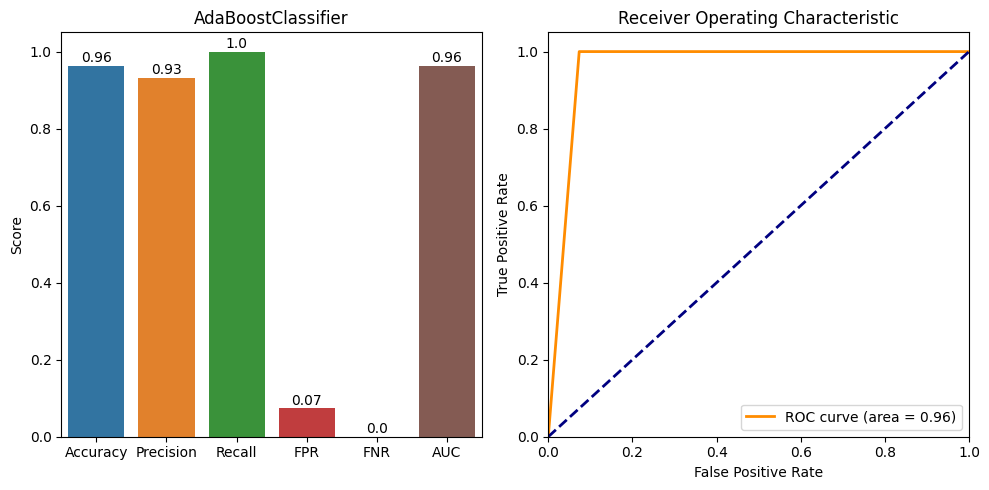

In [109]:
plot_evaluation(y_test, ada.predict(x_test_), ada)

### Gradient Boost

In [110]:
gradient = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, min_samples_split=3, min_samples_leaf=1,verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, tol=0.0001, ccp_alpha=0.0)

In [111]:
gradient.fit(x_train_, y_train)

GradientBoostingClassifier(min_samples_split=3, n_estimators=500)

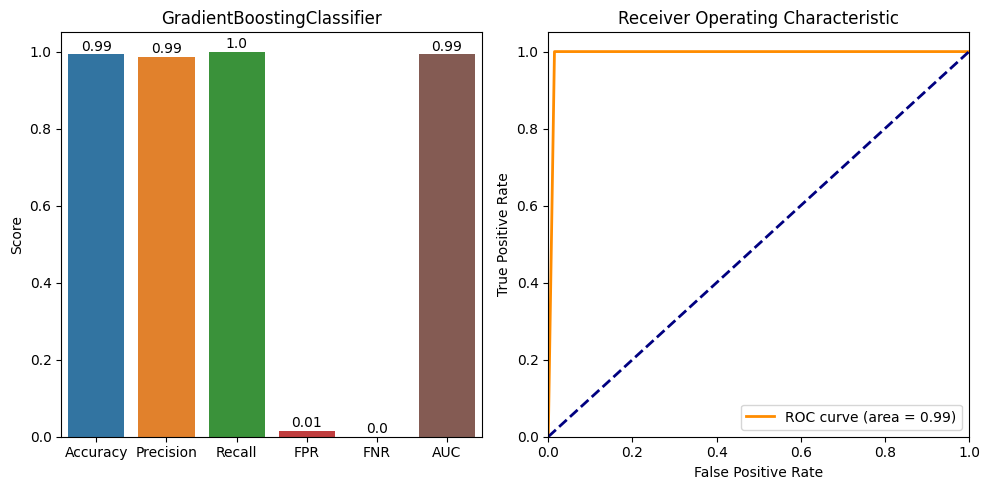

In [112]:
plot_evaluation(y_test, gradient.predict(x_test_), gradient)

### Bagging Classifier

In [113]:
bag = BaggingClassifier(estimator=GradientBoostingClassifier(), n_estimators=300)
bag.fit(x_train_, y_train)

BaggingClassifier(estimator=GradientBoostingClassifier(), n_estimators=300)

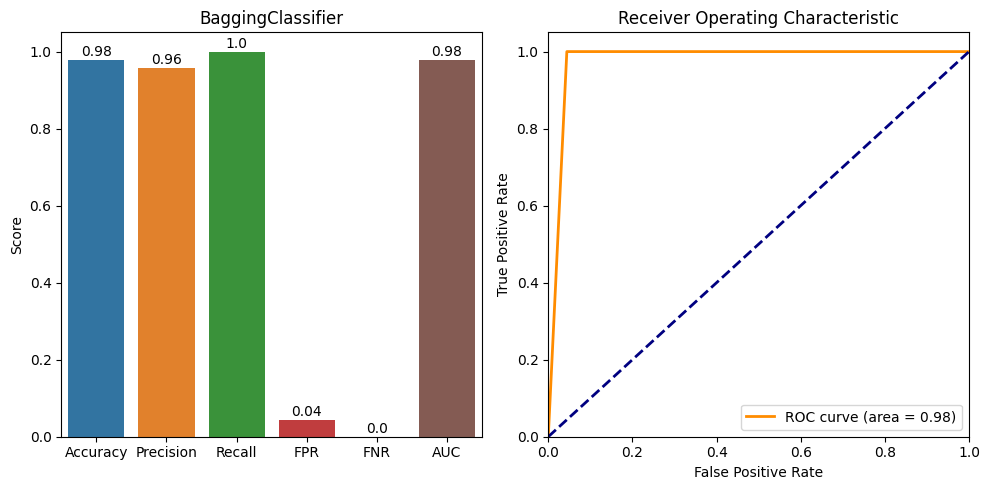

In [114]:
plot_evaluation(y_test, bag.predict(x_test_), bag)

### Voting Classifier

In [115]:
voting = VotingClassifier(
     estimators=[('Gradient', gradient), ('rf', randomforest), ('bag', bag), ('LR', model)],
     voting='soft')

In [116]:
voting.fit(x_train_, y_train)

VotingClassifier(estimators=[('Gradient',
                              GradientBoostingClassifier(min_samples_split=3,
                                                         n_estimators=500)),
                             ('rf', RandomForestClassifier()),
                             ('bag',
                              BaggingClassifier(estimator=GradientBoostingClassifier(),
                                                n_estimators=300)),
                             ('LR', LogisticRegression())],
                 voting='soft')

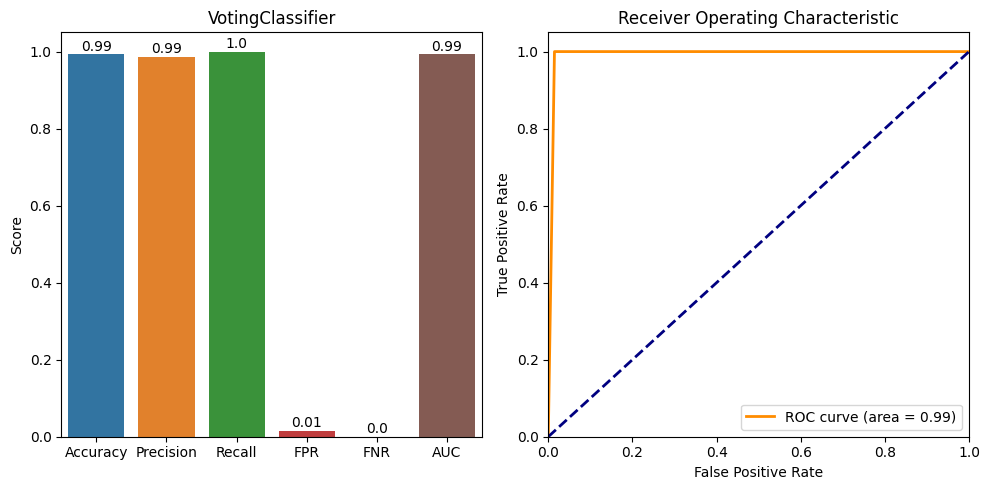

In [117]:
plot_evaluation(y_test, voting.predict(x_test_), voting)

### Nearest Neighbors

In [118]:
knn = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
knn.fit(x_train_, y_train)
pred = knn.predict(x_test_)

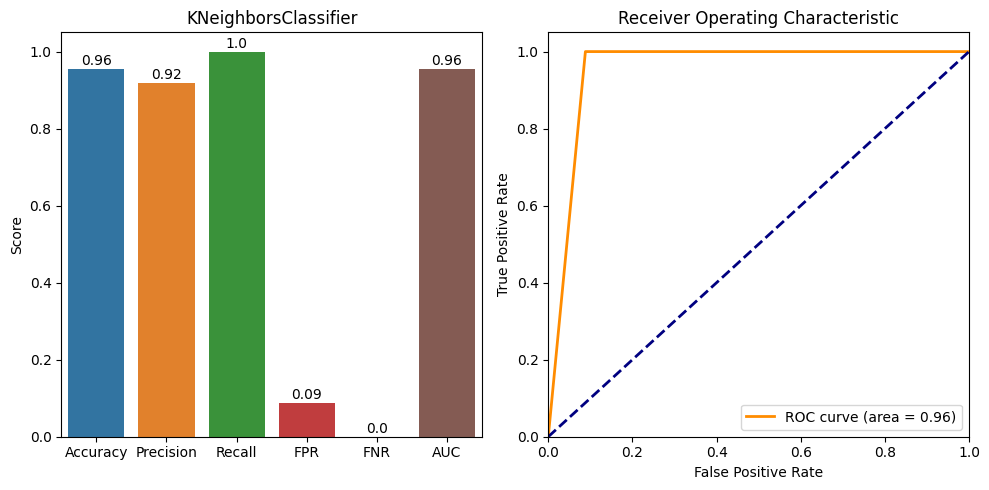

In [119]:
plot_evaluation(y_test, pred, knn)

### SVC

In [120]:
svc = SVC(C=2)
svc.fit(x_train_, y_train)
pred = svc.predict(x_test_)

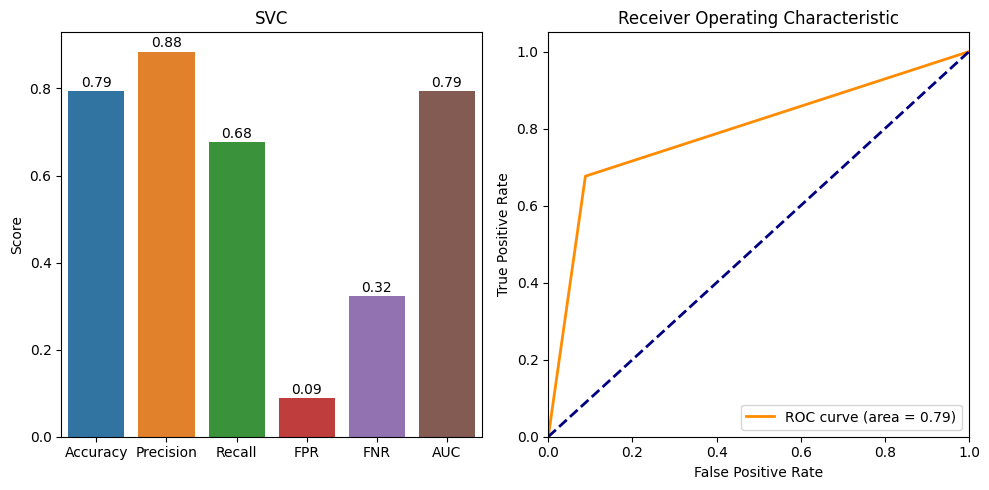

In [121]:
plot_evaluation(y_test, svc.predict(x_test_), svc)

In [84]:
x = scaler.fit_transform(x)

### Cross Validation Score

In [85]:
# logistic_score = cvs(model, x, y)
# gradient_score = cvs(gradient, x, y)
# ada_score = cvs(ada, x, y)
# bag_score = cvs(bag, x, y)
# tree_score = cvs(tree, x, y)
# randomforest_score = cvs(randomforest, x, y)
# knn_score = cvs(knn, x, y)
# svc_score = cvs(svc, x, y)
# voting_score = cvs(voting, x, y)
# xgb_score = cvs(xgb, x, y)


/home/anonymous/envs/langchain/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anonymous/envs/langchain/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anonymous/envs/langchain/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anonymous/envs/langchain/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

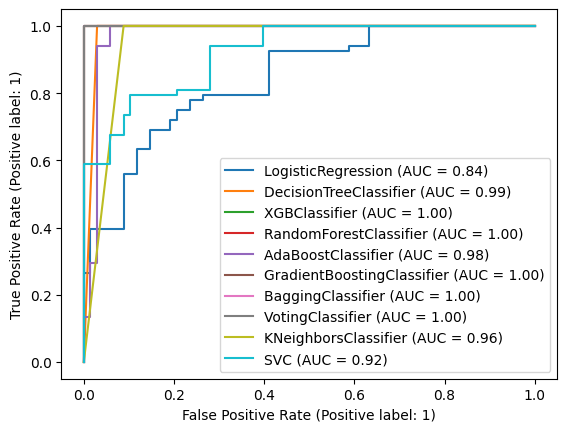

In [122]:
ROC_curve = RocCurveDisplay.from_estimator(model, x_test_, y_test)
ROC_curve = RocCurveDisplay.from_estimator(tree, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(xgb, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(randomforest, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(ada, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(gradient, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(bag, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(voting, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(knn, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(svc, x_test_, y_test, ax=ROC_curve.ax_)


In [86]:
scores = [
    logistic_score,
    gradient_score,
    ada_score,
    bag_score,
    tree_score,
    randomforest_score,
    knn_score,
    svc_score,
    voting_score,
    xgb_score
]
labels = [
    'Logistic',
    'Gradient',
    'Ada',
    'Bag',
    'Tree',
    'Randomforest',
    'KNN',
    'SVC',
    'Voting',
    'XGB'
]


In [87]:
dataset = {
    'data': data,
    'models': {
        'logistic': model,
        'gradient': gradient,
        'ada': ada,
        'bag': bag,
        'tree': tree,
        'randomforest': randomforest,
        'knn': knn,
        'svc': svc,
        'voting': voting,
        'xgb': xgb
    },
    'scores': scores,
    'labels': labels,
    'x': x,
    'y': y,
    'x_train': x_train_,
    'x_test': x_test_,
    'y_train': y_train,
    'y_test': y_test
}

In [88]:
import pickle
file = '../mw1I.pkl'

# Save the models dictionary to the pickle file
with open(file, 'wb') as file:
    pickle.dump(dataset, file)